In [1]:
#install the required modules
!pip install efficientnet
!pip install nnAudio

     |████████████████████████████████| 50 kB 523 kB/s 
     |████████████████████████████████| 43 kB 178 kB/s 


In [2]:
#import the required libraries
import pandas as pd
import math
import numpy as np
import random

from tensorflow.keras.utils import Sequence
from tensorflow.keras import Sequential, utils, optimizers, metrics
import tensorflow as tf
import tensorflow.keras.layers as layers
from tensorflow.keras.models import load_model

import matplotlib
matplotlib.use('nbagg')

from matplotlib import pyplot as plt,mlab as mlb

from sklearn.model_selection import train_test_split

from random import shuffle
from nnAudio.Spectrogram import CQT1992v2
import torch


from efficientnet.tfkeras import EfficientNetB0, EfficientNetB1

from scipy import signal, fft
from scipy.interpolate import interp1d
from scipy.signal import butter, filtfilt, iirdesign, zpk2tf, freqz
from scipy.signal import welch

import os
import time
import seaborn as sns
from copy import copy,deepcopy

%matplotlib inline

2022-05-11 07:52:49.678721: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
/opt/conda/lib/python3.7/site-packages/nnAudio/Spectrogram.py:7: Warning: importing Spectrogram subpackage will be deprecated soon. You should import the feature extractor from the feature subpackage. See actual documentation.
  category=Warning,


In [3]:
# set path for dataset as inp_dir
class Config:
    inp_dir=r"../input/g2net-gravitational-wave-detection"
    s_freq=2048
    s_time=2
    TRAIN_ROOT = f"{inp_dir}/train/"
    TEST_ROOT = f"{inp_dir}/test/"
    l_r=2e-4
    no_workers=8
config=Config()

In [4]:
#Data Processing module
class Data:
    def __init__(self,in_dir):
        self.inp_d=in_dir
        
    def np_array(self,i,train=True):
        c_0,c_1,c_2=[i[0],i[1],i[2]]
        if train:
            fp=f"{config.TRAIN_ROOT}{c_0}/{c_1}/{c_2}/{i}.npy"
        else:
            fp=f"{config.TEST_ROOT}{c_0}/{c_1}/{c_2}/{i}.npy"
        return np.load(fp)
    targets=pd.read_csv(f"{config.inp_dir}/training_labels.csv")
    y=targets["target"].values
    all_identifiers = targets["id"].values
    id_1=targets[targets["target"] == 1]["id"].values
    id_0=targets[targets["target"] == 0]["id"].values
    sample_submission=pd.read_csv(f"{config.inp_dir}/sample_submission.csv")
    def np_array_normalized(self,i,train=True):
        x=self.np_array(i,train)
        x_n=[0]*len(x)
        x_n[0]=x[0]/np.max(x[0])
        x_n[1]=x[1]/np.max(x[1])
        x_n[2]=x[2]/np.max(x[2])
        return x_n
    def GW_np(self,i,train=True):
        x={q:w for q,w in zip(['L','H','V'],self.np_array(i,train))}
        x_n={q:w for q,w in zip(['L','H','V'],self.np_array_normalized(i,train))}
        return {'a':x,'a_n':x_n}
    def cqt_spectrogram(self,i,train=True):
        cqt = CQT1992v2(sr=config.s_freq,hop_length=64, fmin=20, fmax=1024, bins_per_octave=12, norm=1, window='hann', center=True, pad_mode='reflect', trainable=False, output_format='Magnitude', verbose=False)
        waveform=np.hstack(self.np_array(i,train))
        waveform=waveform/np.max(waveform)
        waveform=torch.from_numpy(waveform).float()
        cqt_image=cqt(waveform)
        cqt_image=np.array(cqt_image)
        cqt_image=np.transpose(cqt_image, (1,2,0))
        return cqt_image
    def spectrogram(self,i,train=True):
        waveform=np.hstack(self.np_array(i,train))
        waveform=waveform/np.max(waveform)
        (freq,time,intensity)=signal.spectrogram(waveform,config.s_freq, mode="magnitude", scaling="spectrum", window=('kaiser', 14))
        return (freq,time,intensity)

In [5]:
#Data Visualization Module
class DataVisualization(Data):
    def __init__(self,in_dir):
        Data.__init__(self,in_dir)
    def plot(self,i,l,n=False,train=True):
        x=self.GW_np(i)['a_n'][l] if n else self.GW_np(i)['a'][l]
        plt.figure(figsize=(20,5))
        plt.plot(x)
        plt.xlabel("sample")
        plt.ylabel(l+" strain") if not n else plt.ylabel(l+"n_strain")
        plt.title(f"timeseries plot of data {i} - {self.targets[self.targets['id']==i].target.values}")
    def plot_hstack(self,i,n=False,train=True):
        x=self.GW_np(i)['a'] if n==False else self.GW_np(i)['a_n']
        x=[*x.values()]
        plt.figure(figsize=(20,5))
        plt.plot(np.hstack(x))
        plt.xlabel("sample")
        plt.ylabel("n_strain") if n else plt.ylabel("strain")
        plt.title(f"hstack of data {i} - {self.targets[self.targets['id']==i].target.values}")
    def plot_parallel(self,i,n=False,train=True):
        x=x=self.GW_np(i)['a'] if n==False else self.GW_np(i)['a_n']
        plt.figure(figsize=(20,5))
        plt.plot(x['L'], color="red", label="L")
        plt.plot(x['H'], color="green", label="H")
        plt.plot(x['V'], color="blue", label="V")
        plt.xlabel("sample")
        plt.ylabel("n_strain") if n else plt.ylabel("strain")
        plt.legend()
        plt.title(f"timeseries plot of data {i} - {self.targets[self.targets['id']==i].target.values}")    
    def plot_cqt_spectrogram(self,i,train=True):
        image=self.cqt_spectrogram(i,train)
        plt.figure(figsize=(20,5))
        plt.imshow(image)
        plt.xlabel("scaled time")
        plt.ylabel("scaled frequency")
        plt.legend()
        plt.title(f"CQT1992 (nnAudio) spectrogram of hstack'd data {i} - {self.targets[self.targets['id']==i].target.values}")
    def plot_spectrogram(self,i,train=True):
        (f,t,it)=self.spectrogram(i,train)
        plt.figure(figsize=(20,5))
        plt.pcolormesh(t,f,it,shading='gouraud')
        plt.ylabel('Frequency [Hz]')
        plt.xlabel('Time [sec]')
        plt.ylim(0,100)
        plt.title(f"Scipy spectrogram of hstack'd data {i} - {self.targets[self.targets['id']==i].target.values}")

x=DataVisualization(config.inp_dir)

In [6]:
#Whitten to remove gaussian nosie and CQT transform 
def whiten(s, interp_psd, dt):
    fq=np.fft.rfftfreq(len(s),dt)
    FT=np.fft.rfft(s)
    w_FT=FT/(np.sqrt(interp_psd(fq)/dt/2))
    w_FT=np.fft.irfft(w_FT,n=len(s))
    return w_FT

def cqt_1992(d):
    d_c=np.hstack(d)
    d_c=np.hstack(d)/np.max(d)
    spectrogram_creator=CQT1992v2(
        sr=2048, hop_length=64, fmin=20, fmax=1024, verbose=False
    )
    im=spectrogram_creator(torch.from_numpy(d_c).float())[0]
    r=np.stack([im,im,im],axis = -1)
    return r

f=cqt_1992

In [7]:
#Sample data used for testing
s_id_0=np.random.choice(x.targets[x.targets['target']==0]['id'].values,1)[0]
s_id_1=np.random.choice(x.targets[x.targets['target']==1]['id'].values,1)[0]

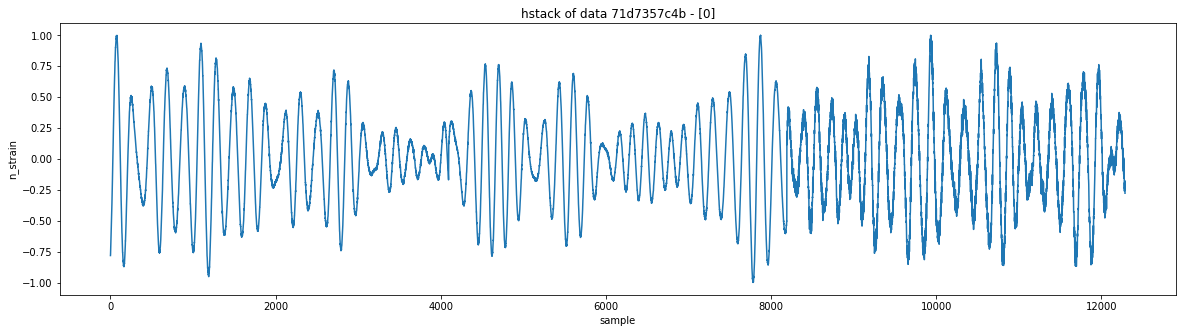

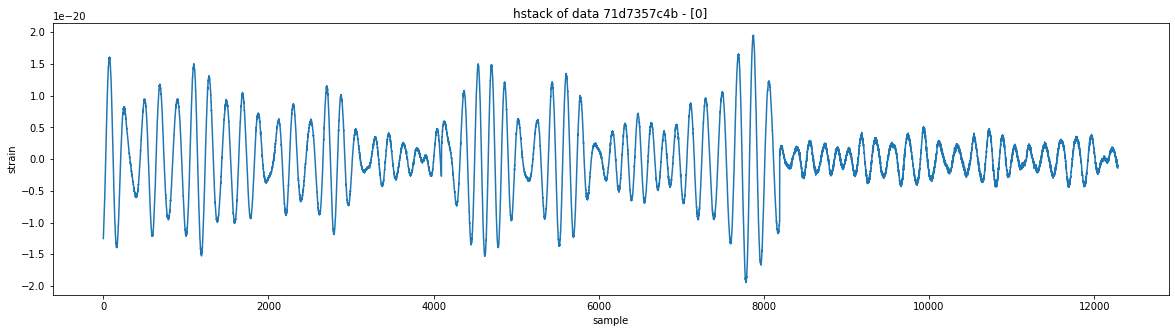

In [8]:
x.plot_hstack(s_id_0,True)
x.plot_hstack(s_id_0)

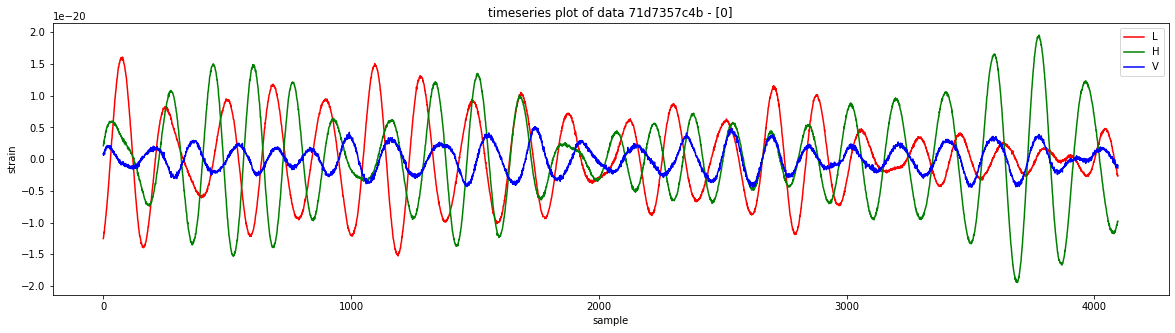

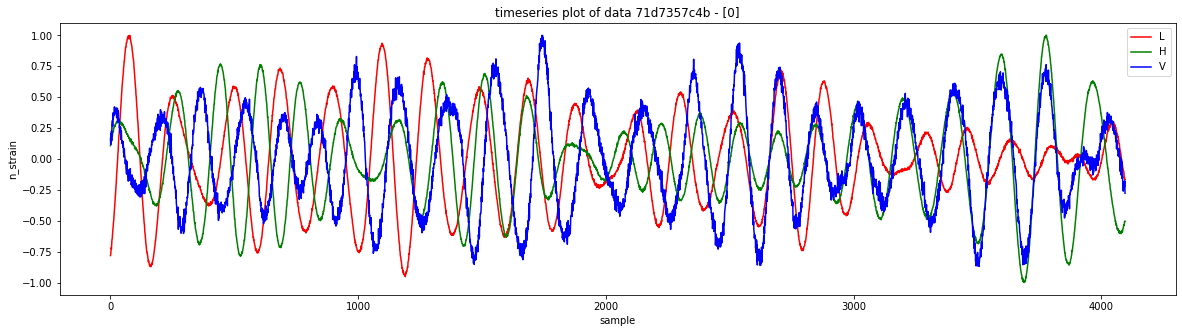

In [9]:
x.plot_parallel(s_id_0)
x.plot_parallel(s_id_0,True)

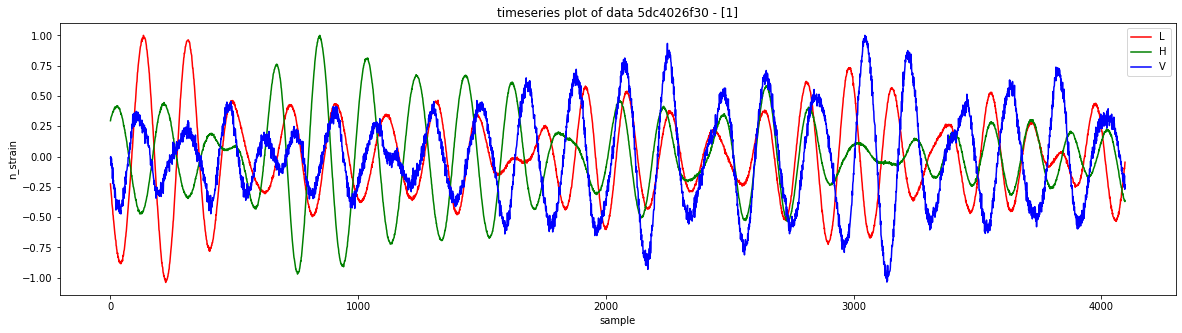

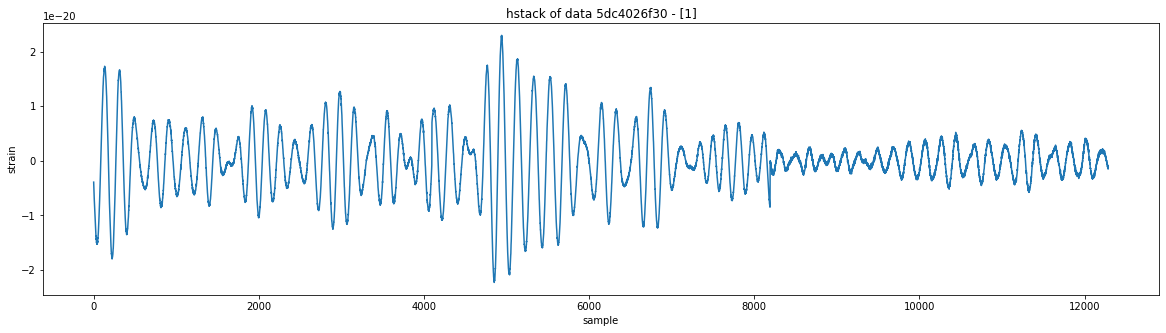

In [10]:
x.plot_parallel(s_id_1,True)
x.plot_hstack(s_id_1)

/opt/conda/lib/python3.7/site-packages/nnAudio/utils.py:429: SyntaxWarning: If fmax is given, n_bins will be ignored
  warnings.warn("If fmax is given, n_bins will be ignored", SyntaxWarning)


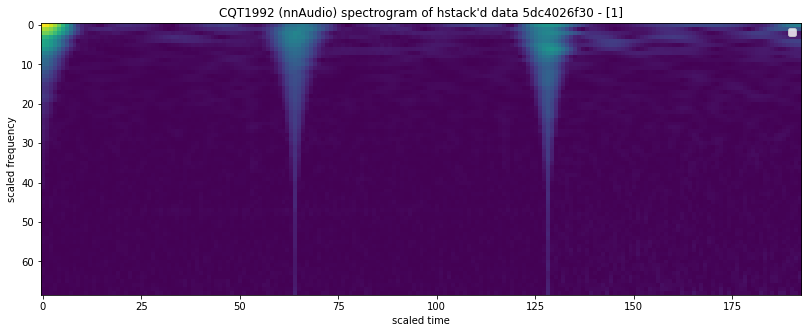

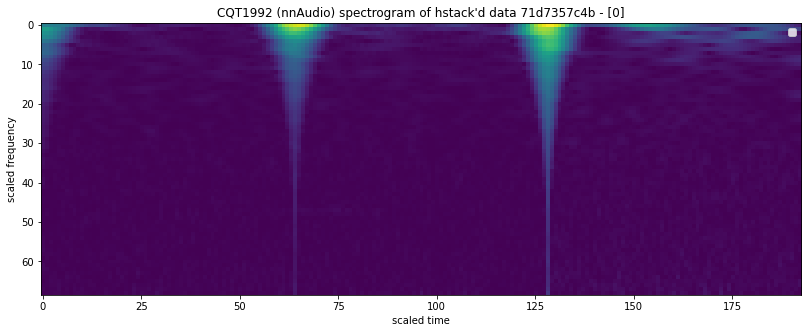

In [11]:
x.plot_cqt_spectrogram(s_id_1)
x.plot_cqt_spectrogram(s_id_0)

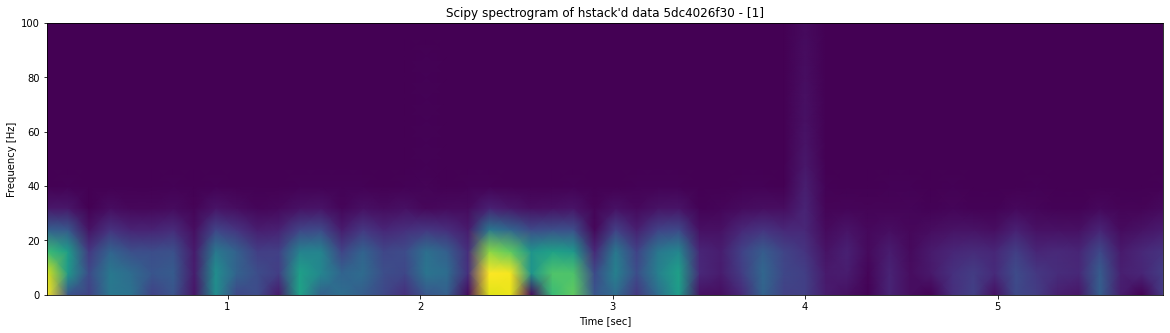

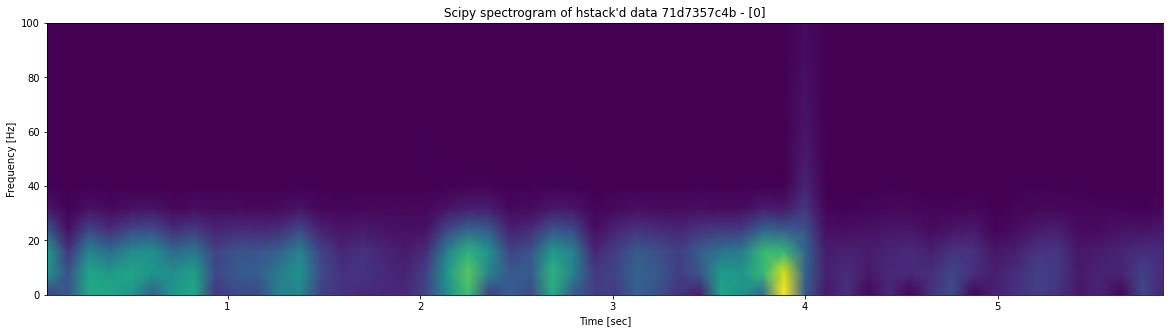

In [12]:
x.plot_spectrogram(s_id_1)
x.plot_spectrogram(s_id_0)

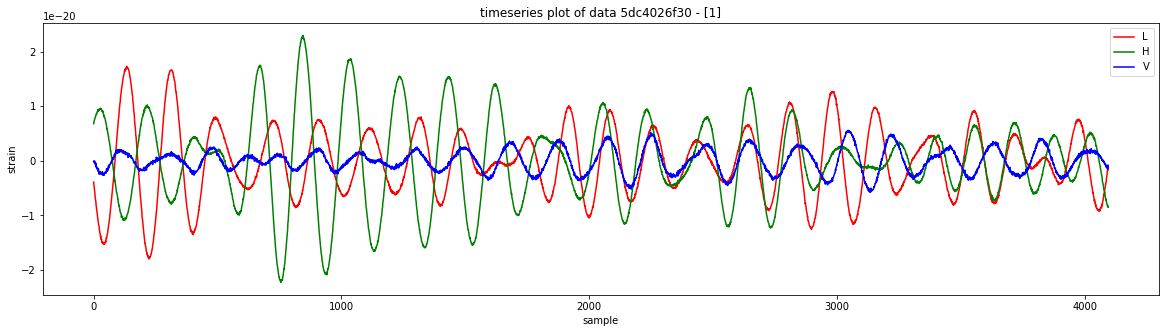

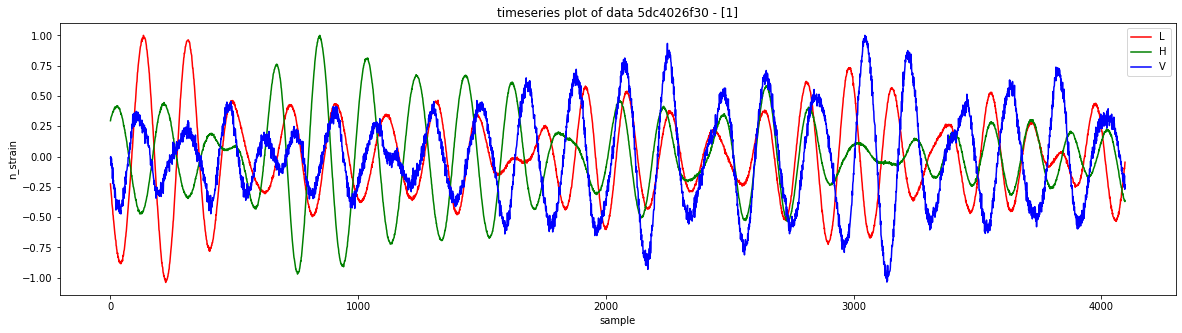

In [13]:
x.plot_parallel(s_id_1)
x.plot_parallel(s_id_1,True)

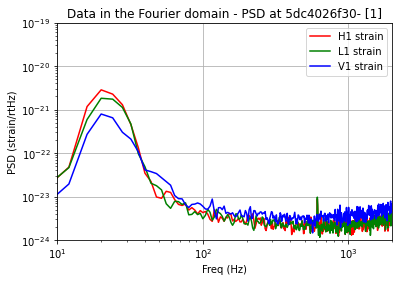

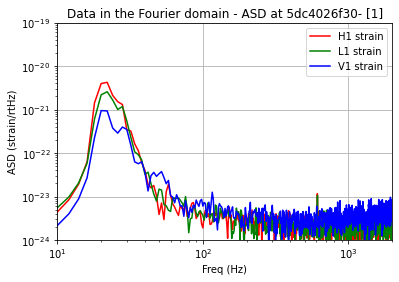

In [14]:
def PSD(t_id):
    fs=config.s_freq*2
    fmin = 10
    fmax = 2000
    strain=x.GW_np(t_id)
    f,Pxx_H1 = welch(strain['a']['H'], fs, nperseg=1024)
    f,Pxx_L1 = welch(strain['a']['L'], fs, nperseg=1024)
    f,Pxx_V1 = welch(strain['a']['V'], fs, nperseg=1024)
    plt.figure()
    plt.loglog(f,np.sqrt(Pxx_H1),'r',label='H1 strain')
    plt.loglog(f,np.sqrt(Pxx_L1),'g',label='L1 strain')
    plt.loglog(f,np.sqrt(Pxx_V1),'b',label='V1 strain')
    plt.axis([fmin, fmax, 1e-24, 1e-19])
    plt.grid('on')
    plt.ylabel('PSD (strain/rtHz)')
    plt.xlabel('Freq (Hz)')
    plt.legend(loc='upper right')
    plt.title(f'Data in the Fourier domain - PSD at '+t_id+'- ['+str(x.targets[x.targets['id'] == t_id].target.values[0])+']')
PSD(s_id_1)

def ASD(t_id):
    NFFT = 1*config.s_freq
    fmin = 10
    fmax = 2000
    fs=config.s_freq*2
    strain=x.GW_np(t_id)
    Pxx_H1,f = mlb.psd(strain['a']['H'], Fs = fs, NFFT = NFFT)
    Pxx_L1,f = mlb.psd(strain['a']['L'], Fs = fs, NFFT = NFFT)
    Pxx_V1,f = mlb.psd(strain['a']['V'], Fs = fs, NFFT = NFFT)

    psd_H1 = interp1d(f, Pxx_H1)
    psd_L1 = interp1d(f, Pxx_L1)
    psd_V1 = interp1d(f, Pxx_V1)

    plt.figure()
    plt.loglog(f, np.sqrt(Pxx_H1),'r',label='H1 strain')
    plt.loglog(f, np.sqrt(Pxx_L1),'g',label='L1 strain')
    plt.loglog(f, np.sqrt(Pxx_V1),'b',label='V1 strain')
    plt.axis([fmin, fmax, 1e-24, 1e-19])
    plt.grid('on')
    plt.ylabel('ASD (strain/rtHz)')
    plt.xlabel('Freq (Hz)')
    plt.legend(loc='upper right')
    plt.title(f'Data in the Fourier domain - ASD at '+t_id+'- ['+str(x.targets[x.targets['id'] == t_id].target.values[0])+']')
ASD(s_id_1)

In [15]:
#TO create a DataGenerator Object to pass in the dataset as input to the training model
class DataGenerator(tf.keras.utils.Sequence):
    
    def __init__(self,path,list_IDs,data,batch_size):
            self.path=path
            self.list_IDs=list_IDs
            self.data=data
            self.batch_size=batch_size
            self.indexes=np.arange(len(self.list_IDs))
    
    def __len__(self):
        len_=int(len(self.list_IDs)/self.batch_size)
        if len_*self.batch_size<len(self.list_IDs):
            len_+=1
        return len_
    
    def __data_generation(self, list_IDs_temp):
        X=np.zeros((self.batch_size,l,w,h))
        y=np.zeros((self.batch_size, 1))
        for i,ID in enumerate(list_IDs_temp):
            id_=self.data.loc[ID, 'id']
            file=id_+".npy"
            path_in='/'.join([self.path, id_[0], id_[1], id_[2]]) + '/'
            data_array=np.load(path_in+file)
            X[i, ]=f(data_array)
            y[i, ]=self.data.loc[ID, 'target']
        return X,y
    
    def __getitem__(self, index):
        indexes = self.indexes[index * self.batch_size : (index+1) * self.batch_size]
        list_IDs_temp = [self.list_IDs[k] for k in indexes]
        X, y = self.__data_generation(list_IDs_temp)
        return X, y

In [16]:
train_labels = pd.read_csv(f"{config.inp_dir}/training_labels.csv")
train_ids = train_labels['id'].values
y = train_labels['target'].values
train_indices, validation_indices = train_test_split(list(train_labels.index))
l,w,__=x.cqt_spectrogram(s_id_1).shape
h=3
print(len(train_indices))
print(len(validation_indices))
train_gen = DataGenerator(config.inp_dir+'/train/', train_indices, train_labels, 64)
valid_gen = DataGenerator(config.inp_dir+'/train/', validation_indices, train_labels, 64)

420000
140000


/opt/conda/lib/python3.7/site-packages/nnAudio/utils.py:429: SyntaxWarning: If fmax is given, n_bins will be ignored
  warnings.warn("If fmax is given, n_bins will be ignored", SyntaxWarning)


In [17]:
#2-D CNN Model
def get_model():
    model = tf.keras.Sequential()
    
    model.add(tf.keras.layers.Conv2D(filters=16,kernel_size=3,input_shape=(l,w,h),activation='relu',))
    model.add(tf.keras.layers.MaxPooling2D(pool_size=2))

    model.add(tf.keras.layers.Conv2D(filters=32,kernel_size=3,input_shape=(l,w,h),activation='relu',))
    model.add(tf.keras.layers.MaxPooling2D(pool_size=2))

    model.add(tf.keras.layers.Conv2D(filters=64,kernel_size=3,input_shape=(l,w,h),activation='relu',))
    model.add(tf.keras.layers.MaxPooling2D(pool_size=2))

    model.add(tf.keras.layers.Flatten())

    model.add(tf.keras.layers.Dense(512,activation="relu"))
    model.add(tf.keras.layers.Dense(128,activation="relu")) 
    model.add(tf.keras.layers.Dense(32,activation="relu")) 
    model.add(tf.keras.layers.Dense(1,activation="sigmoid"))

    model.compile(
        optimizer = tf.keras.optimizers.Adam(learning_rate=config.l_r),
        loss = 'binary_crossentropy',
        metrics=['accuracy', tf.keras.metrics.TruePositives(), tf.keras.metrics.FalsePositives(), tf.keras.metrics.TrueNegatives(), tf.keras.metrics.FalseNegatives()]
    )
    
    return model

model=get_model()
model.summary()

2022-05-11 07:53:12.265329: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-05-11 07:53:12.269021: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2022-05-11 07:53:12.327744: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-11 07:53:12.328868: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:00:04.0 name: Tesla P100-PCIE-16GB computeCapability: 6.0
coreClock: 1.3285GHz coreCount: 56 deviceMemorySize: 15.90GiB deviceMemoryBandwidth: 681.88GiB/s
2022-05-11 07:53:12.328926: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
2022-05-11 07:53:12.358450: I tensorflow/stream_executor/platform/def

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 67, 191, 16)       448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 33, 95, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 31, 93, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 15, 46, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 13, 44, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 6, 22, 64)         0         
_________________________________________________________________
flatten (Flatten)            (None, 8448)              0

In [18]:
#Set true if the model is'nt saved
Train=False
if Train:
    history = model.fit(train_gen, validation_data=valid_gen, epochs = 1)
    #set the file location to save the file as intended
    model.save('/kaggle/working/trained_cnn.h5')
    model.save_weights('/kaggle/working/trained_cnn_weights.h5')
else:
    #use the file location where the file was saved
    print("Using the pre-trained model for prediction")
    model=load_model('../input/cnn-weights/trained_cnn1.h5')
    model.load_weights('../input/lolnoob/trained_cnn_1.h5')

Using the pre-trained model for prediction


In [19]:
#Prediction Function that takes the path to the LIGO signal file as input and outputs the confidence score of that being GW signal
def Predict(path):
    t=np.load(path)
    return model.predict(cqt_1992(t).reshape(1,69,193,3))

In [20]:
Target_1_test=['0000bb9f3e.npy','00026119ef.npy','0003920ef5.npy']
Target_0_test=['0003a9d0b0.npy','0003d34cd0.npy','000a3072ab.npy']
qq_1=Target_1_test[1]
qq_0=Target_0_test[2]

In [21]:
#Predicted confidence value for detector noise + signal sample
Predict('../input/g2net-gravitational-wave-detection/train/0/0/0/{}'.format(qq_1))

2022-05-11 07:53:16.492084: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2022-05-11 07:53:16.505777: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2199995000 Hz
2022-05-11 07:53:16.690891: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.11
2022-05-11 07:53:17.686160: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublasLt.so.11
2022-05-11 07:53:17.701522: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.8


array([[0.7403573]], dtype=float32)

In [22]:
#Predicted confidence score for just detector noise sample
Predict('../input/g2net-gravitational-wave-detection/train/0/0/0/{}'.format(qq_0))

array([[0.5146883]], dtype=float32)